# Plot terminus picks over images and terminus position time series

#### Jukes Liu

## 1) Set-up

In [1240]:
# import sys
# # !{sys.executable} -m pip install fiona
# !{sys.executable} -m pip install opencv-python

In [1275]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import cv2
import pandas as pd    
from time import sleep
from IPython.display import clear_output
import scipy.stats
import datetime
import shutil

csvpaths = '/home/jukes/Documents/Sample_glaciers/'
basepath = '/media/jukes/jukes1/LS8aws/'
massorsize = "mass"

### Read in data from csv files

1) Read in __image dates__ from imgdates.csv

In [1276]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(csvpaths+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(datetime_df.shape)
datetime_df.head()

(864, 2)


Scene   datetimes
510   LC80090132013101LGN01  2013-04-11
1612  LC80090142013101LGN01  2013-04-11
577   LC82330172013102LGN01  2013-04-12
940   LC82330152013102LGN01  2013-04-12
445   LC80080142013110LGN01  2013-04-20

2) Read in csv with the __metric and order__ for each terminus pick from terminuspicks_massorsize_date.csv

In [1277]:
analysis_date = '2019_10_30'

order_df = pd.read_csv(csvpaths+'terminuspicks_'+analysis_date+'.csv', sep=',', dtype=str, header=1, usecols=[0,1,2,3,4])
order_df = order_df.dropna()
print(order_df.shape)
order_df.head(10)

(4638, 5)


BoxID                  Scene Scale            Metric Order
0   001  LC80310052014242LGN00   004   5600.5618286133     5
1   001  LC80310052014242LGN00   003   8399.8723754883     4
2   001  LC80310052014242LGN00   002  16463.2495117188     3
3   001  LC80310052014242LGN00   001  32791.9229736328     2
4   001  LC80310052014242LGN00   000  66196.5776367188     1
5   001  LC80310052014226LGN00   006   1841.3379821777     5
6   001  LC80310052014226LGN00   003  15520.2913513184     4
7   001  LC80310052014226LGN00   002  20833.6751403809     3
8   001  LC80310052014226LGN00   001  42189.2700195312     2
9   001  LC80310052014226LGN00   000  90920.1655273438     1

3) Read in __centerline information__ for each terminus box rom Boxes_coords_pathrows.csv

In [1278]:
centerline_df = pd.read_csv(csvpaths+'Boxes_coords_pathrows.csv', sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')
print(centerline_df.shape)
centerline_df

(10, 4)


midpoint_x midpoint_y            cline_slope     cline_intercept
BoxID                                                                 
001        117.0      164.5   -0.11888111888111888   178.4090909090909
002        468.0      575.5    0.03345070422535211   559.8450704225352
004        500.0      651.0    -0.2899305555555556   795.9652777777778
033        362.5      473.0  -0.006185567010309278  475.24226804123714
120        111.0      148.5   0.055944055944055944   142.2902097902098
174        260.5      344.5    -0.3231939163498099   428.6920152091255
235        177.0      201.0     0.2222222222222222  161.66666666666669
259        215.0      484.0     0.0705521472392638   468.8312883435583
277        144.5      204.0   -0.04891304347826087   211.0679347826087
531        166.0      250.5   -0.15637860082304528   276.4588477366255

4) Read in __glacier velocities__ from Glacier_velocities.csv

In [1279]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv(csvpaths+'Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

### Define functions:

There are 4 functions that are used throughout the script. __calc_changerates()__ takes a dataframe containing terminus positions and dates of analysis and calculates the terminus change rates. __remove_dips()__ takes a dataframe and a flow speed threshold and removes all points that show an unrealistically large negative change rate followed by an unrealistically large positive change rate. __remove_jumps()__ takes the same inputs and removes all values that show an unrealistically large positive change rate (a jump). __within()__ takes a test value and determines whether it is within a given interval around the set value. This is used for determining whether the points of the centerline "intersect" with the terminus pick points.

In [1280]:
#define a function to calculate terminus change rate:
def calc_changerates(df):
    original_len = df.shape[0]
    terminus_changerates = []
    
    for i in range(0, len(df.index)):
        date = list(df['datetimes'])[i]
        term_position = list(df['term_position'])[i]
        scene = list(df['Scene'])[i]
        
        #CALCULATE TERMINUS CHANGE RATE
        #grab the earliest date
        earliestdate = list(df['datetimes'])[0]
        #for the first date, the changerate is nan
        if date == earliestdate:
            changerate = np.NaN
        #for all other subsequent entries:
        else:
            #grab current date and terminus position
            t = date
            x = term_position
        
            #grab previous date of analysis 
            counter = 1
            t_prev = list(df['datetimes'])[i-counter]

            #while the previous date = current date, append the counter and find the previous previous date
            while t_prev == t:
                counter = counter+1
                t_prev = list(df['datetimes'])[i-counter]

            #grab all terminus positions from previous date of analysis:
            prev_df = df[df['datetimes'] == t_prev].copy()

            #grab the one that corresponds to the highest order
            highestorder = np.min(np.array(prev_df['Order']))
            positions = list(prev_df[prev_df['Order']==highestorder].term_position)
            
            #if there are multiple, grab the smallest
            if len(positions) > 1:
                x_prev = np.min(np.array(positions))
                #otherwise, just grab the one
            else:
                x_prev = float(list(positions)[0])

            #calculate terminus change (m)
            delta_x = x - x_prev
            #calculate time change (days)
            delta_t = t - t_prev
            delta_t = delta_t.days

            #Calculate change rate!
            changerate = delta_x/delta_t

        terminus_changerates.append(changerate)
        
    df['changerate'] = terminus_changerates
    return original_len, len(terminus_changerates)

In [1281]:
def remove_dips(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index
        df = df.reset_index(drop=True)

        dip_indices = []

        # for index, row in onepick_df.iterrows():
        for index, row in df.iterrows():
            rate = row['changerate']
            date = row['datetimes']
            #for negative change rates:
            if rate < 0:
                #make the threshold negative
                flow_thresh = -flow_thresh
                #if it's unrealistic (faster than threshold)
                if rate < flow_thresh:
                    #check the next entry only if it's in the range of indices
                    if index+1 < len(df.index):  
                        counter = 1

                        #pick the next immediate rate/date
                        nextrate = df.loc[index+counter]['changerate']
                        nextdate = df.loc[index+counter]['datetimes']                    

                        #while the next date is the same as the current, increment the counter
                        #to grab the next next date until the next date is different from the current
                        while nextdate == date:
                            counter = counter + 1
                            nextrate = df.loc[index+counter]['changerate']
                            nextdate = df.loc[index+counter]['datetimes']

                        #if it's a sudden jump, then we have found a dip. Remove it
                        if nextrate > abs(flow_thresh):
                            dip_indices.append(index)
                            
                #if it's a crazy large negative change, remove it even if there isn't a positive change following
                if rate < -(10*abs(flow_thresh)):
                    dip_indices.append(index)
                    
        print(dip_indices)

        #drop those indices
        df = df.drop(dip_indices)

        #recalculate terminus changerates
        calc_changerates(df)
        
    return df

In [1282]:
def remove_jumps(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index for final_images_df
        df = df.reset_index(drop=True)

        jump_indices = []

        for i in range(0, len(df.index)):
            date = list(df['datetimes'])[i]
            rate = list(df['changerate'])[i]
            tpos = list(df['term_position'])[i]
            index = list(df.index)[i]

            if rate > abs(flow_thresh):
                #remove it:
                jump_indices.append(index)

            #remove drops if they are due to first value for the season
            #grab previous date of analysis 
            counter = 1
            prev_date = list(df['datetimes'])[i-counter]
            #while the previous date = current date, append the counter and find the previous previous date
            while prev_date == date:
                counter = counter+1
                prev_date = list(df['datetimes'])[i-counter]

            delta_date = date - prev_date
            delta_date = delta_date.days

            #if the time gap is more than 2 months, and has a positive change rate
            #and the terminus position is more than 80% of the max,
            tpos_thresh = 0.8*np.max(np.array(df['term_position']))
            #remove it
            if delta_date > 60 and rate > 0:
                if tpos > tpos_thresh:
                    jump_indices.append(index)

        print(jump_indices)
        #drop the indices
        df = df.drop(jump_indices)

        #re_calculate terminus change rates
        calc_changerates(df)
        
    return df

In [1283]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

## 2) Plot analyzed images and terminus picks for one glacier sequentially

If images have not been converted to png from pgm, run the following cell but change the BoxID to the right ID:

In [1250]:
# %%bash

# cd /media/jukes/jukes1/LS8aws/Box277/resized/
# mogrify -format png *.pgm

#### Load in the images, scene names, and dat file names for all the resulting terminus picks

In [1481]:
BOI= '174'
print("Box"+BOI)

metric = "Datfiles/"
imagepath = basepath+"Box"+BOI+"/resized/"

#grab the order_df subset for just the box:
order_box_df = order_df[order_df["BoxID"]==BOI].copy()

# #make results directory in BoxID folder if it doesn't already exist
# if os.path.exists(basepath+"Box"+BOI+"/Results/"):
#     shutil.rmtree(basepath+"Box"+BOI+"/Results/")
#     print("Results folder wiped and new created")
#     os.mkdir(basepath+"Box"+BOI+"/Results/")
# #OTHERWISE, create the folder and download into it
# else:
#     os.mkdir(basepath+"Box"+BOI+"/Results/")
#     print("Results  folder made")

Box174


Drop BoxID column and NaNs from the order_box_df

In [1482]:
order_box_df = order_box_df.drop('BoxID', axis=1)
order_box_df = order_box_df.dropna()
print(order_box_df.shape)
order_box_df.head()

(270, 4)


Scene Scale            Metric Order
2431  LC82330172015332LGN00   004   1236.4288511276     5
2432  LC82330172015332LGN00   003   2488.4548950195     4
2433  LC82330172015332LGN00   002   4916.1850891113     3
2434  LC82330172015332LGN00   001   9800.3552246094     2
2435  LC82330172015332LGN00   000  19325.9810256958     1

In [1483]:
#make lists to store image data and grab image files
image_arrays = []
dats = []
trimdats = []
imgnames = []
boxids = []
scales = []

#image path
imgfiles = os.listdir(imagepath)

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
#         print(imgfile)
        image = mpimg.imread(imagepath+imgfile)
        imgname = imgfile[0:-4]
        scenename = imgname[7:-16]
#         print(imgname, scenename)
        
        pathtodat = imagepath+imgname+".pgm_max_gaussian/"+metric
        datfiles = os.listdir(pathtodat)
        
        #if there are datfiles, grab the trimmed and non-trimmed files
        if len(datfiles) > 1: 
            #find the trimmed dat file and the original
            for dat in datfiles:
                if "trim" in dat:
                    datfile_trim = dat
                    #append to trimmed dats list
                    trimdats.append(datfile_trim)
                    #grab the scale and append the equivalent original dat
                    scale = dat[-7:-4]
                    datfile = "terminus_"+scale+".dat"
                    dats.append(datfile)
                    
                    #append the image array and the image name to the list
                    image_arrays.append(image)
                    imgnames.append(scenename)
                    boxids.append(BOI)
                    scales.append(scale)

print(len(image_arrays), len(dats), len(trimdats), len(imgnames),len(boxids), len(scales))
images_df = pd.DataFrame(list(zip(imgnames, boxids, image_arrays, dats, trimdats, scales)),
              columns=['Scene','BoxID','Image_array', 'Dat_filename', "Trimmed_dat_filename", "Scale"])
print(images_df.shape)

270 270 270 270 270 270
(270, 6)


#### Join dates to images_df by joining on Scene:

In [1484]:
images_df.sort_values(by='Scene')
datetime_df = datetime_df.sort_values(by='Scene')
print(datetime_df.shape)

new_df = images_df.merge(datetime_df, how= 'inner', on = 'Scene')
#sort by ascending datetime
dated_images_df = new_df.sort_values(by='datetimes', ascending = True)
#check the shape
print(dated_images_df.shape)
# dated_images_df.head()

(864, 2)
(270, 7)


#### Join "order" to dated_images_df by joining on scale and scene and sort the dataframe

In [1508]:
final_images_df = dated_images_df.merge(order_box_df, how='inner', on=['Scene', 'Scale'])

#sort the DataFrame by date of delineation from earliest to latest AND order
final_images_df = final_images_df.sort_values(by=['datetimes','Scene','Order'], ascending=True)
print(final_images_df.shape)

(270, 9)


## Calculate terminus positions and terminus change rates by glacier

### Terminus position:

In [1509]:
#LOAD IN REFERENCE POINT to calculate terminus position with respect to
box_midpoint_x = np.float(centerline_df.loc[BOI, 'midpoint_x'])

#GRAB CENTERLINE POINTS
#grab slope and intercept from the dataframe
c_slope = float(centerline_df.loc[BOI]['cline_slope'])
c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
#Read in terminus box raster as an np array
tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.png")
#grab x values from width of the terminus box:
xmin = float(centerline_df.loc[BOI]['midpoint_x'])
xmax = np.max(np.array(list(set(np.nonzero(tbox)[0]))))
c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
c_y = c_slope*c_x + c_intercept

#LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
terminus_positions = []
intersections = []

#for each scene and scale:
for index, row in final_images_df.iterrows():
    trimdat = row['Trimmed_dat_filename']
    dat = row['Dat_filename']
    scene = row['Scene']
    
    #CALCULATE TERMINUS POSITION
    #load in dat files and calculate intersection points
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    term_trimdat = np.loadtxt(datpath+trimdat)
    term_dat = np.loadtxt(datpath+dat)                          

    intersect_xs = []
    intersect_ys = []
    #loop through all the x,y values for the centerline
    for j in range(0, len(c_x)):
        x = c_x[j]
        y = c_y[j]
        interval = 0.6
        #where are the intersections with the terminus pick?
        for dat_x, dat_y in term_trimdat:
            if within(dat_x, x, interval) and within (dat_y, y, interval):
                #intersect_x = dat_x
                #intersect_y = dat_y
                #intersect_found = True
                intersect_xs.append(dat_x)
                intersect_ys.append(dat_y)
    
    #if no intersections are found with the terminus line, append Nans
    if len(intersect_xs) == 0:
        term_position = np.NaN
        intersect_x = np.NaN
        intersect_y = np.NaN
    #if at least one is found:
    else:
        #intersection with the greatest x
        #subtract intersection_x from the box_midpoint_x to get terminus position in meters
        max_index = intersect_xs.index(np.max(intersect_xs))
        intersect_x = intersect_xs[max_index]
        intersect_y = intersect_ys[max_index]
        term_position = (intersect_x - box_midpoint_x)*15.0
    
    #append to lists
    terminus_positions.append(term_position)
    intersections.append([intersect_x, intersect_y])
    
# ADD TERMINUS POSITION AND CHANGERATES BACK INTO THE DATAFRAME
final_images_df['term_position'] = terminus_positions
final_images_df['intersections'] = intersections
print(final_images_df.shape)

(270, 11)


Drop NaNs to get rid of any terminus picks where there is no intersection with the centerline and no calculated terminus position:

In [1510]:
final_images_df = final_images_df.dropna()
print(final_images_df.shape)

(251, 11)


### Terminus change rates (m/d):
Convert dates into datetime objects for rate calculations and timeseries plotting

In [1511]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = final_images_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
final_images_df['datetimes'] = datetime_objs

#### Calculate terminus change rates

In [1512]:
calc_changerates(final_images_df)

(251, 251)

In [1520]:
final_images_df = onepick_df

## 3) Show each image & all (up to 5) terminus picks at a time:

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

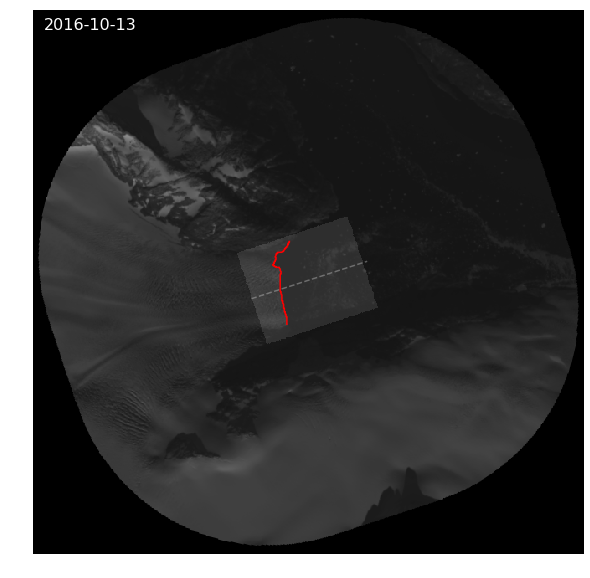

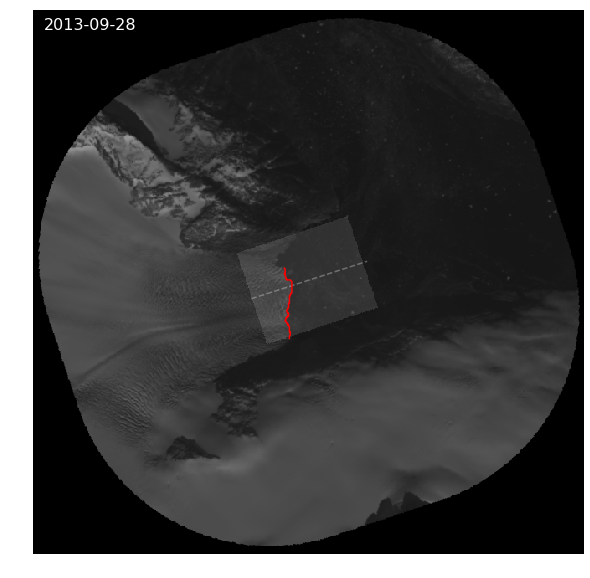

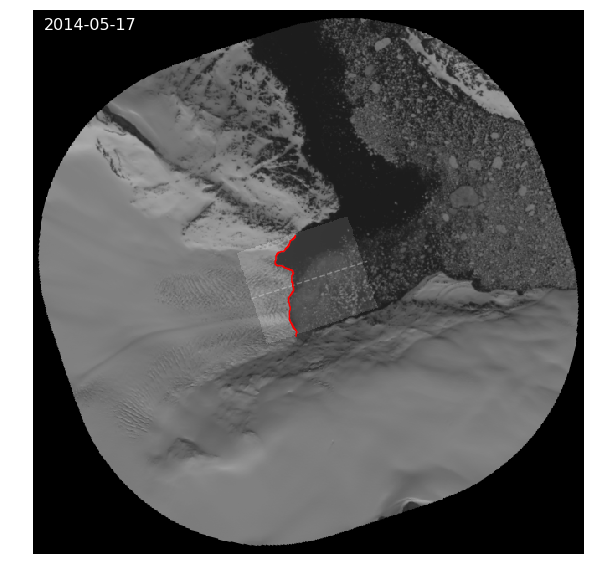

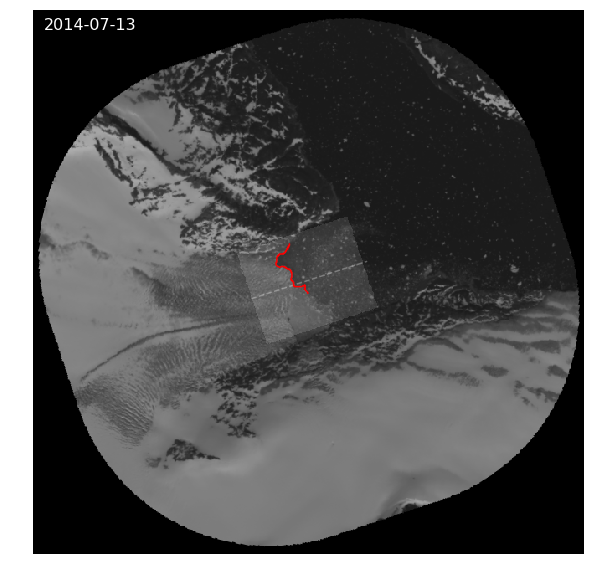

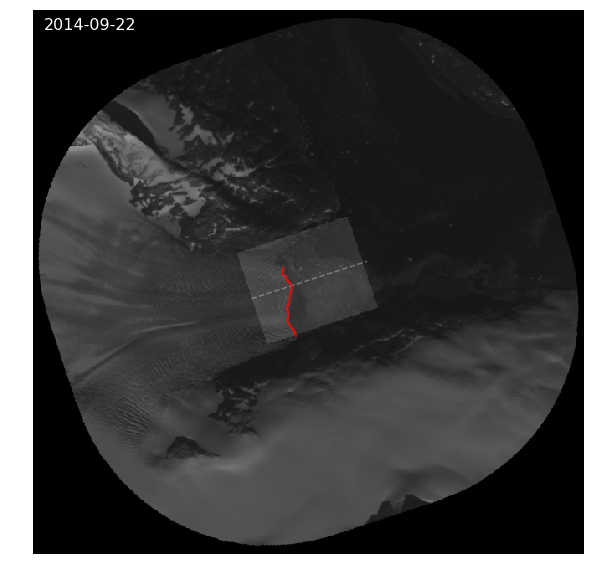

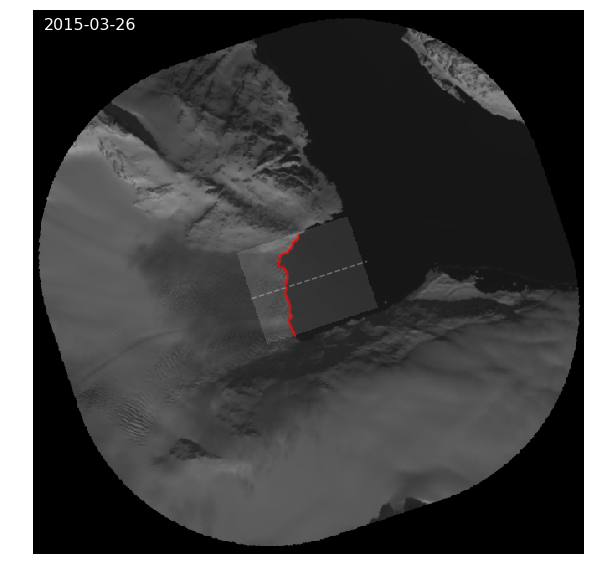

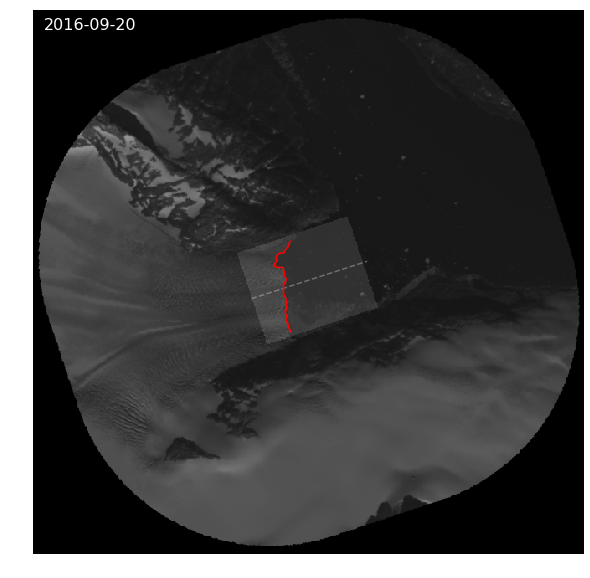

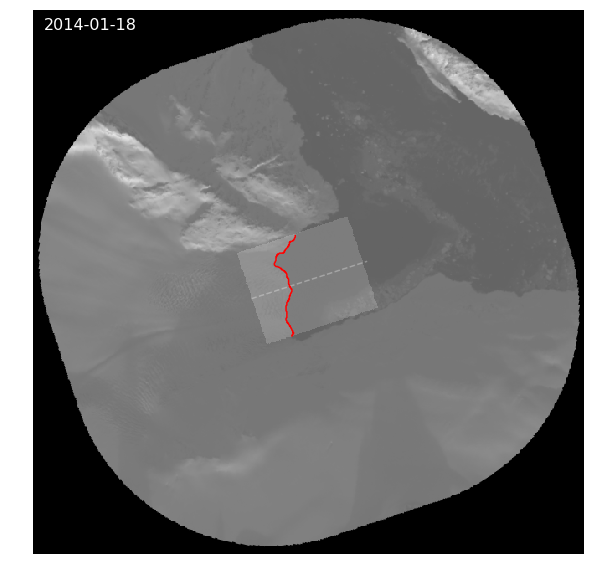

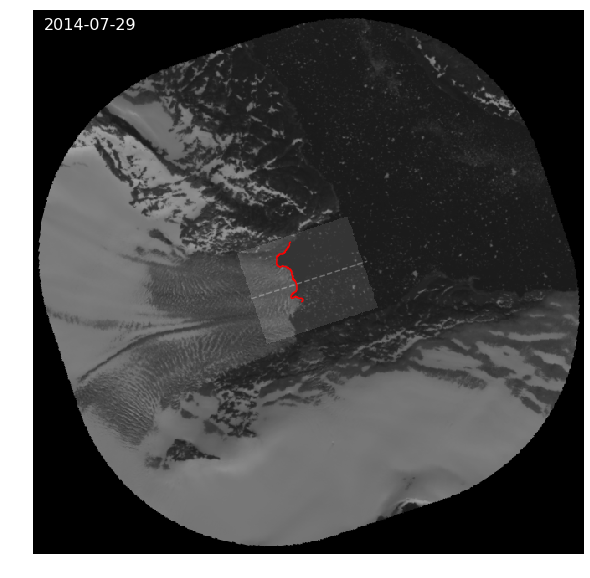

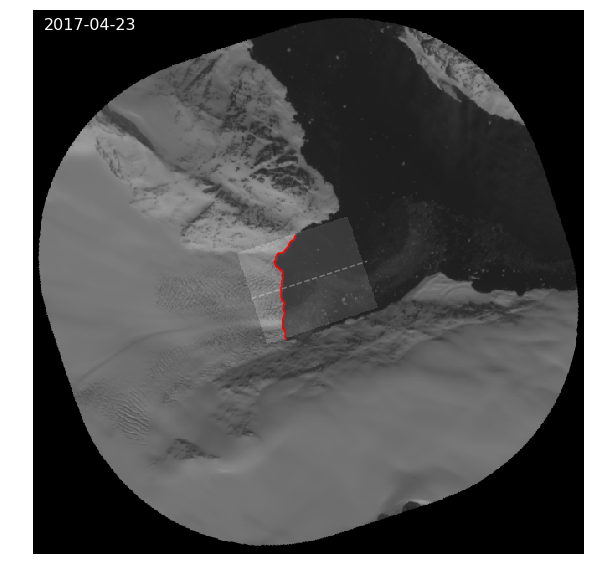

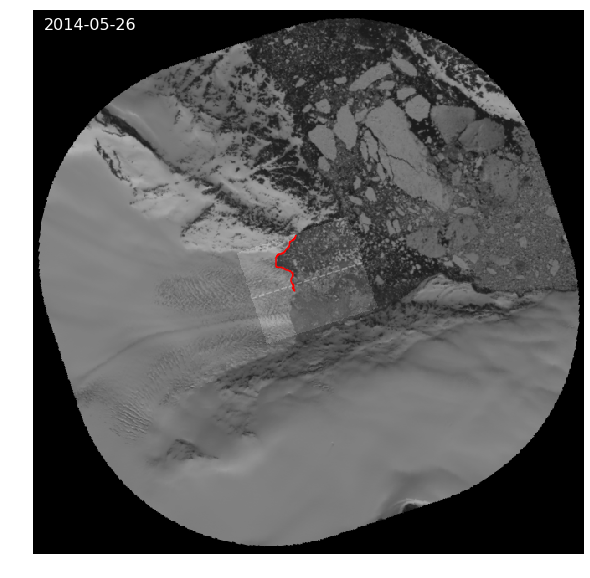

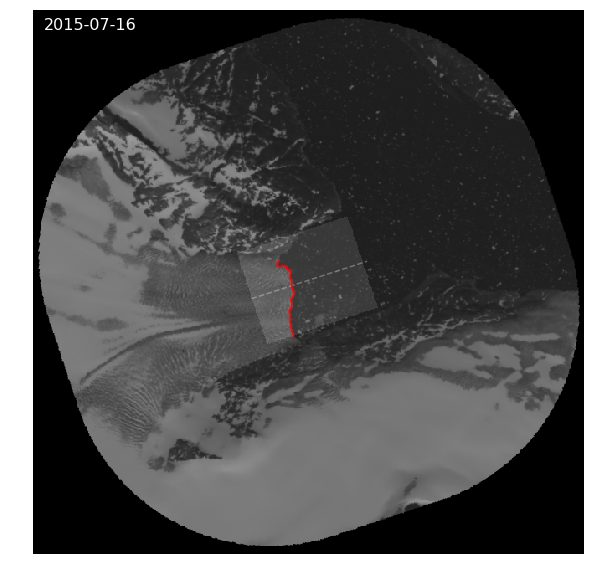

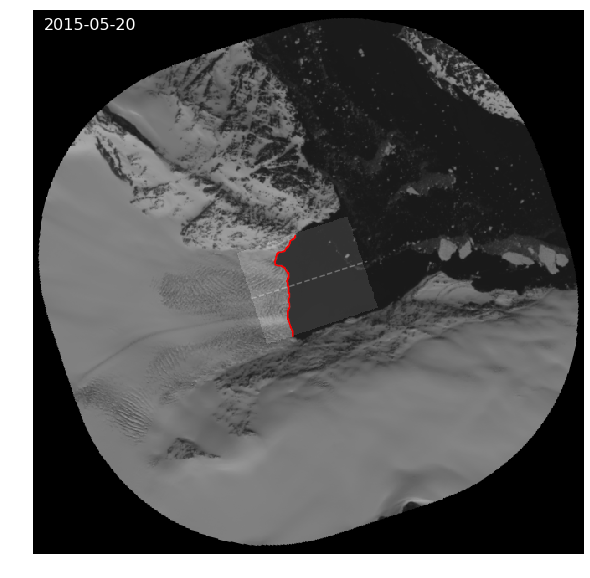

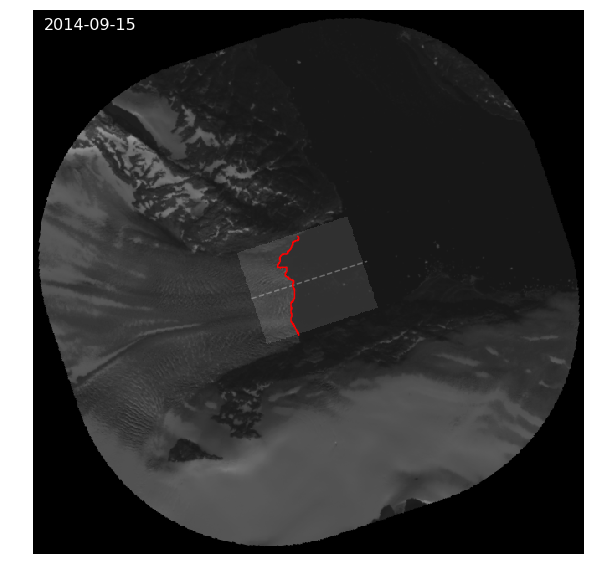

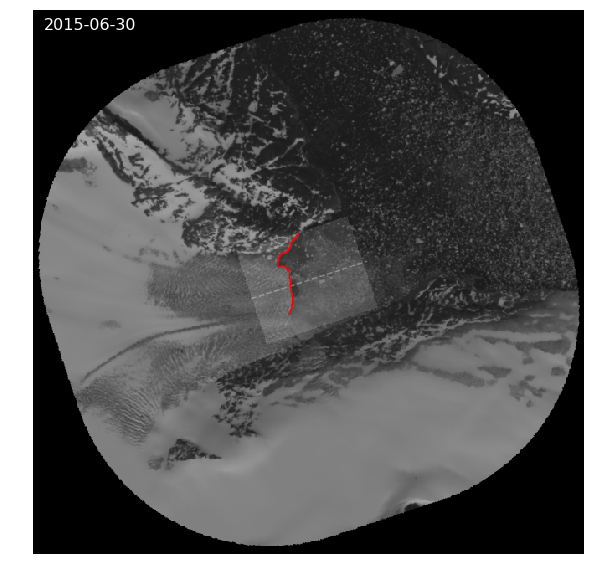

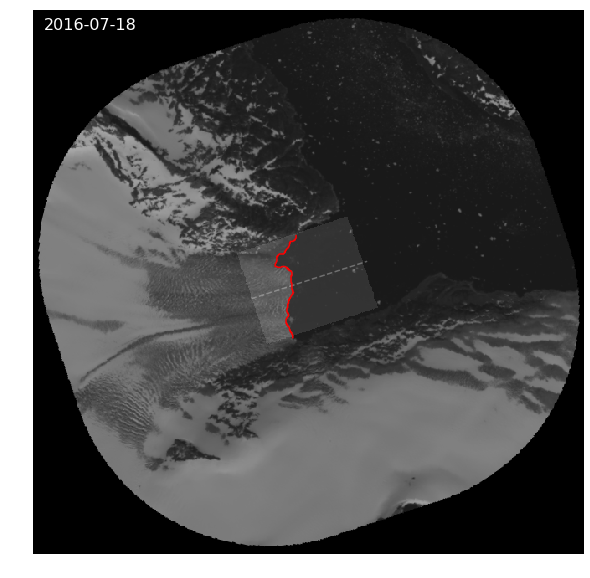

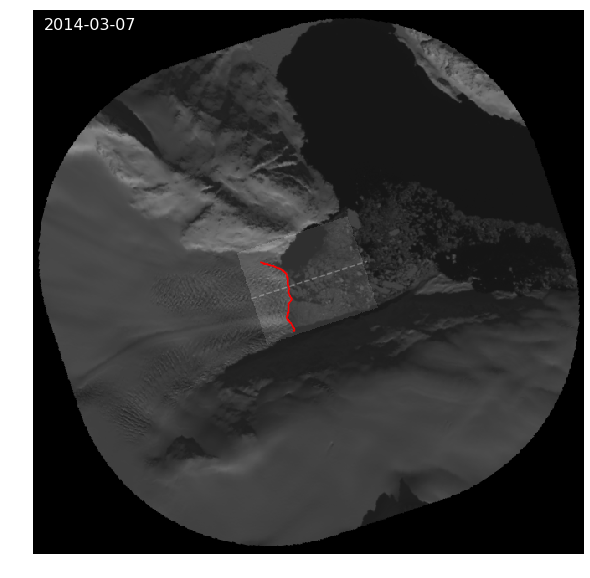

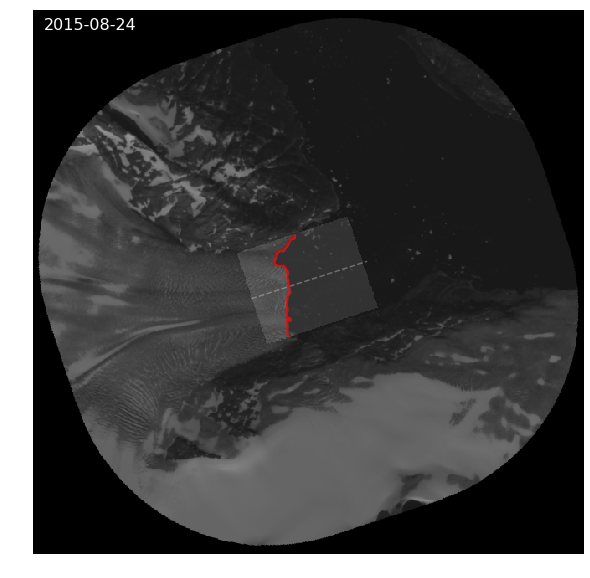

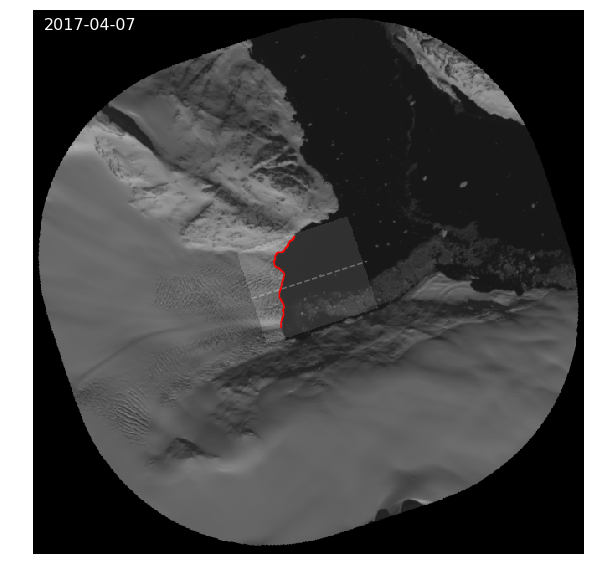

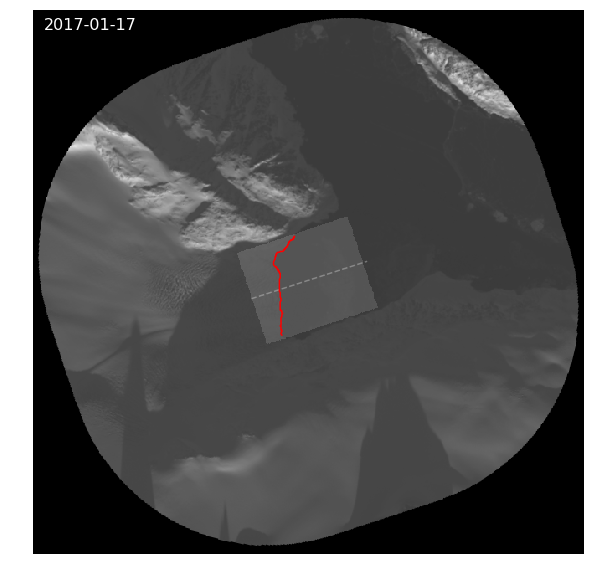

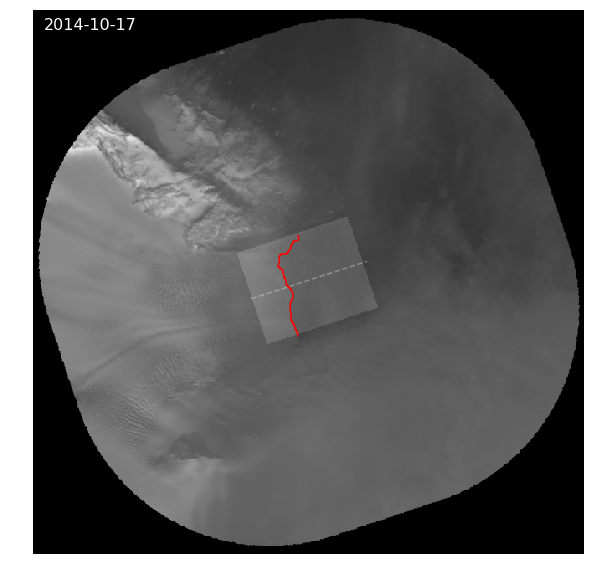

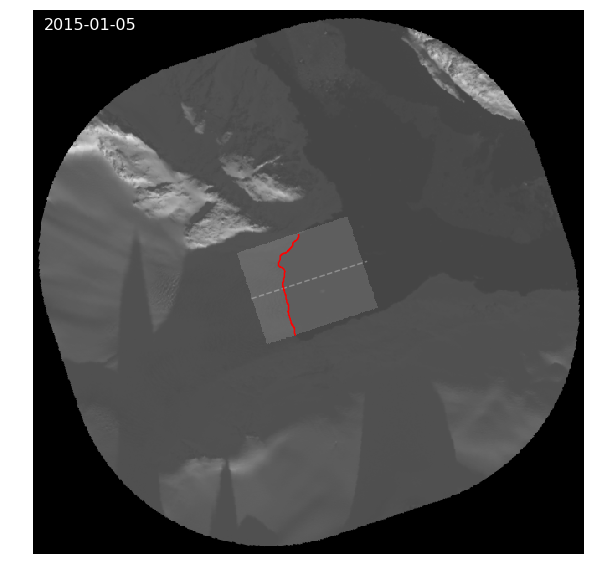

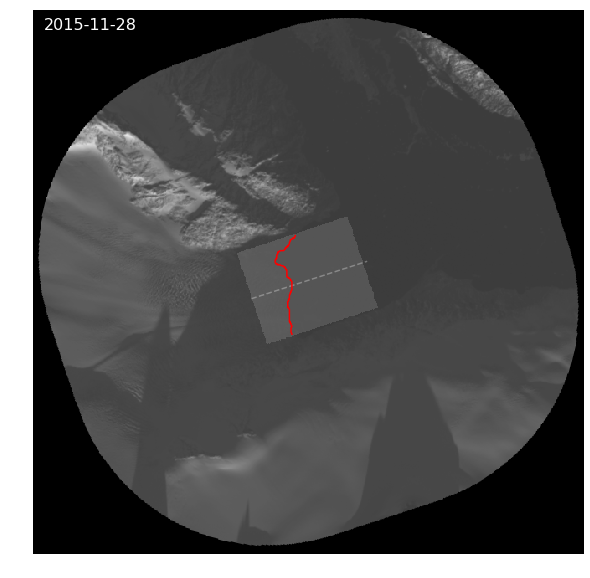

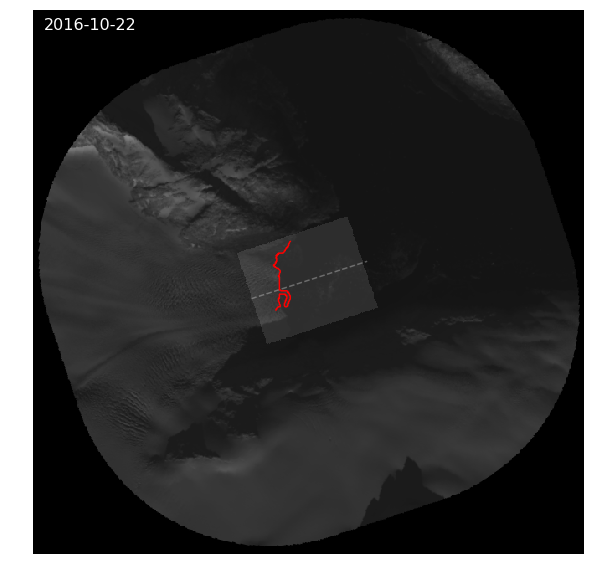

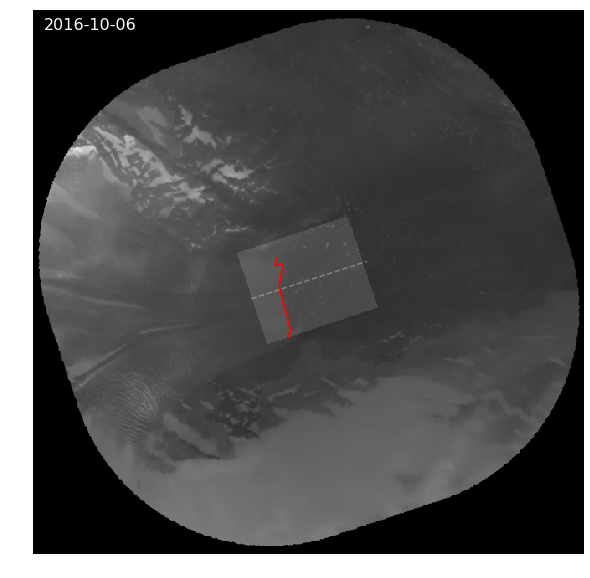

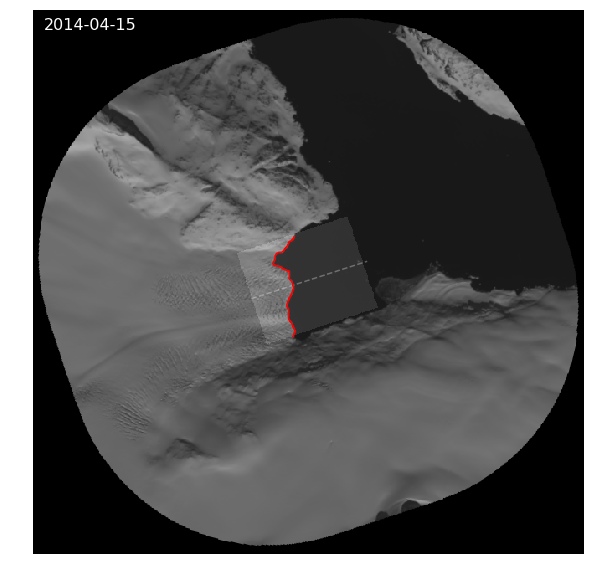

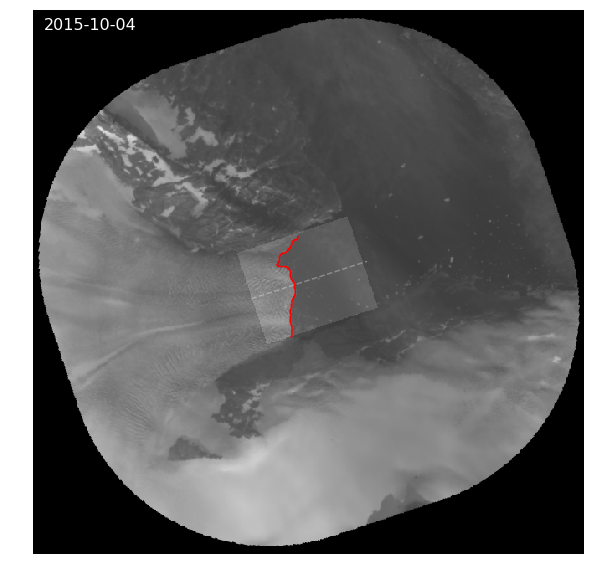

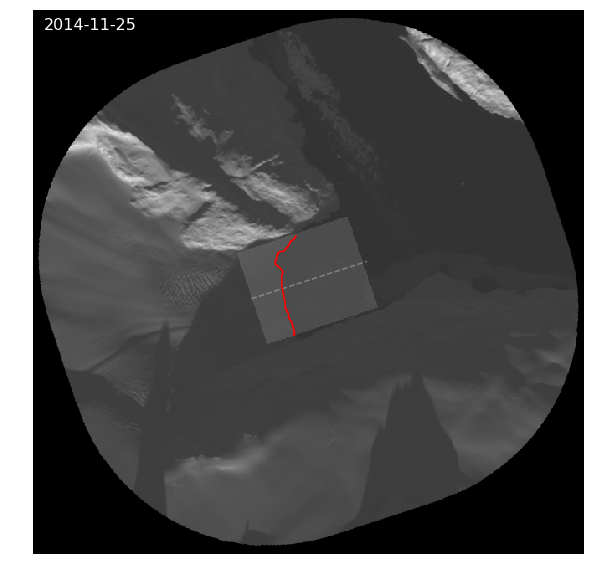

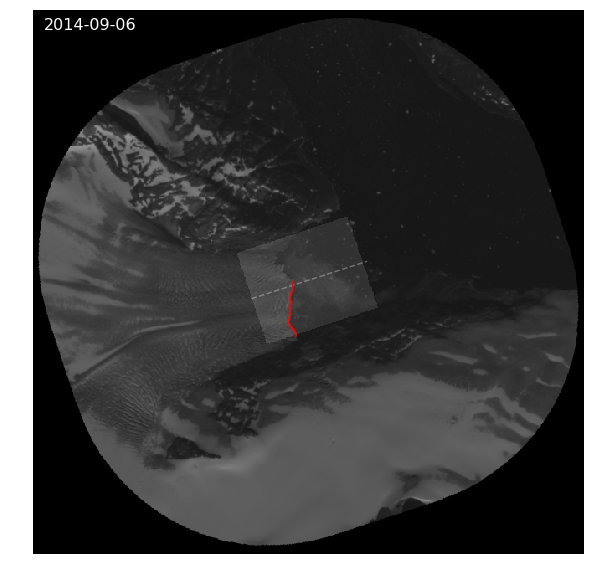

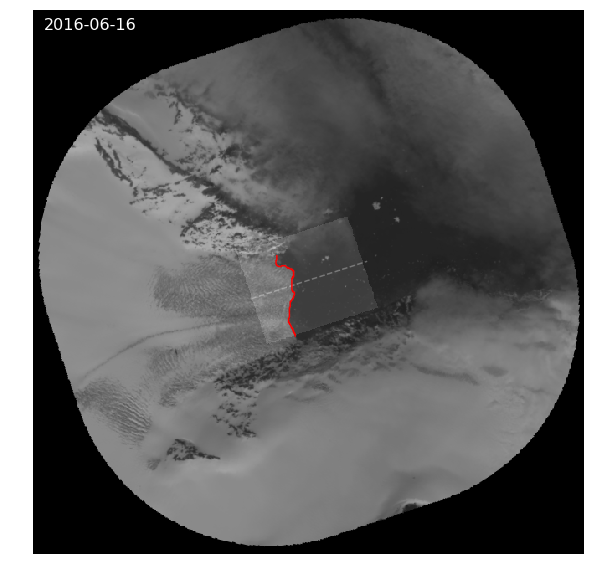

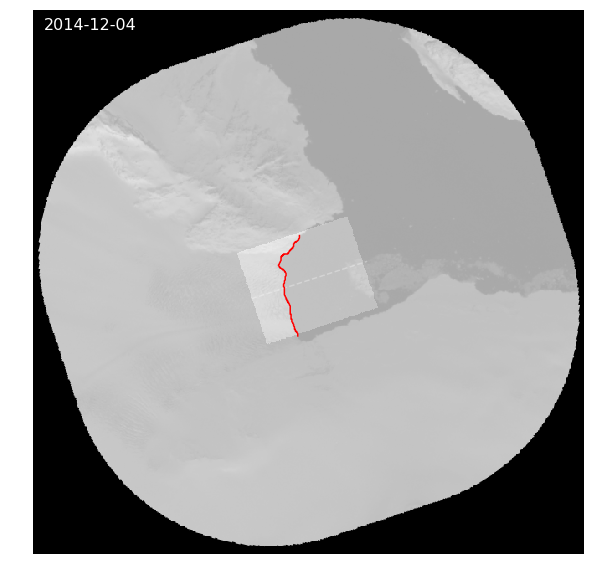

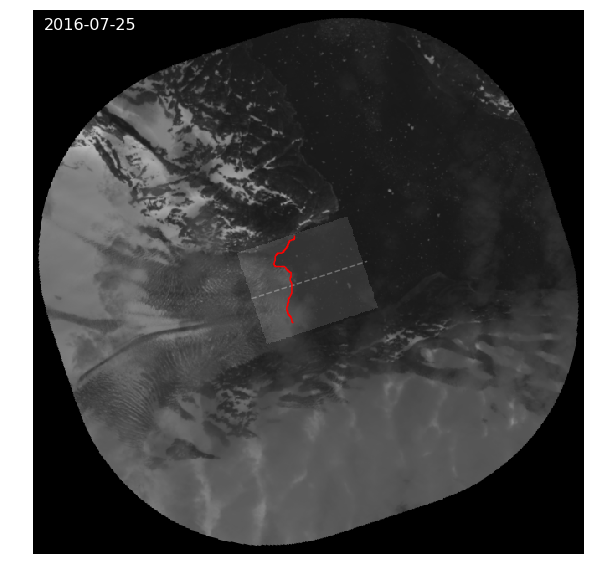

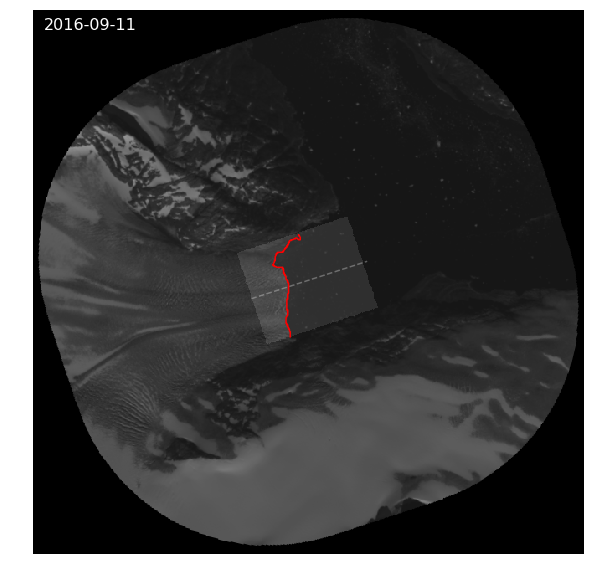

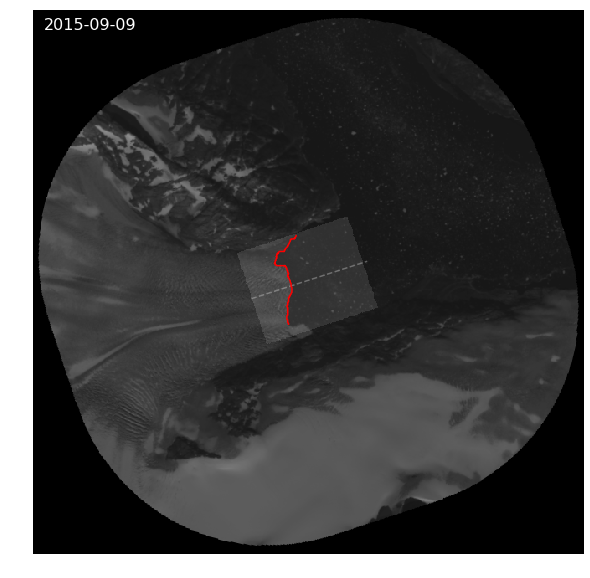

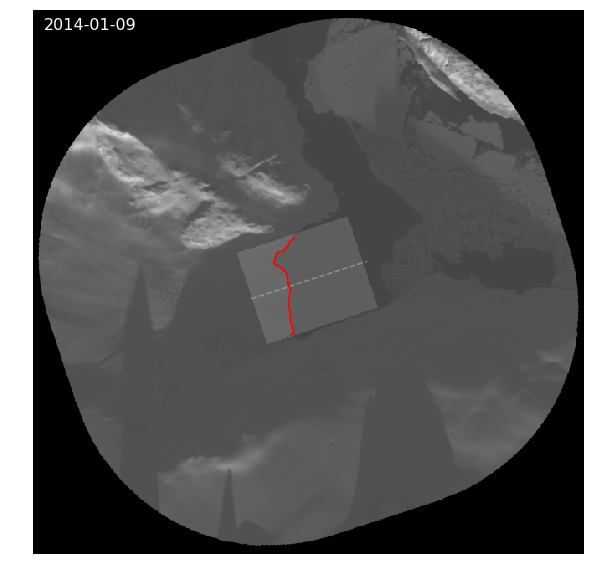

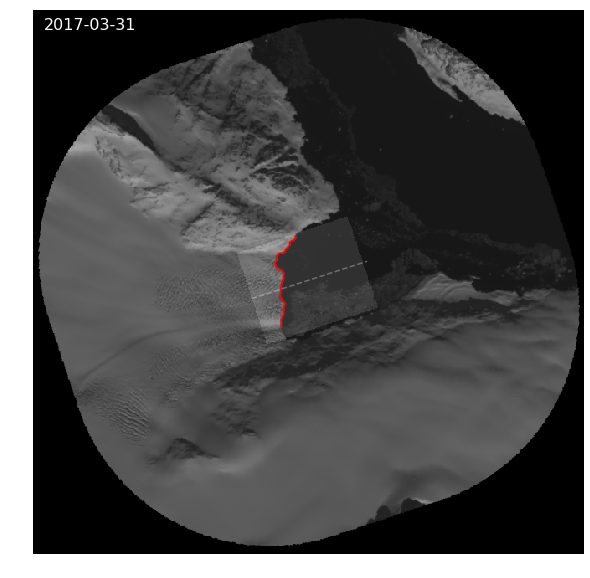

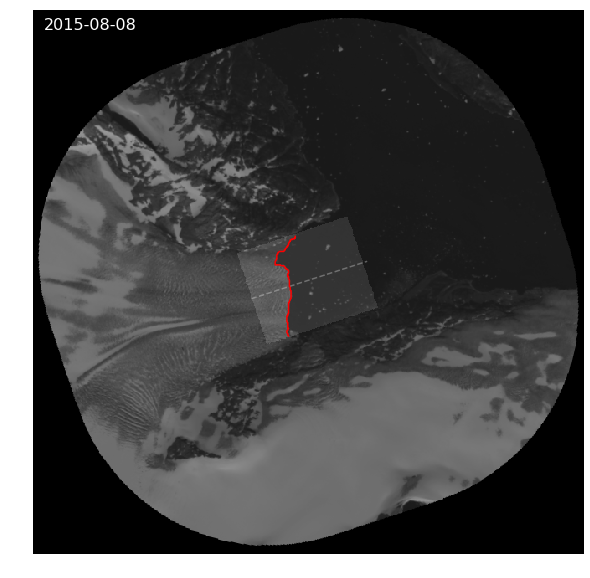

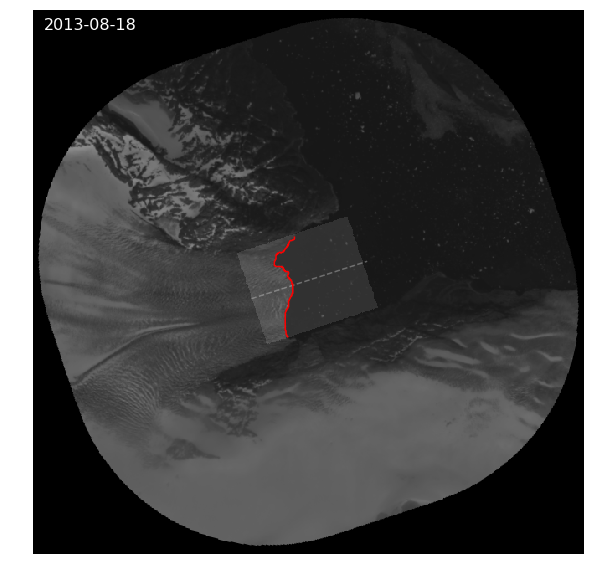

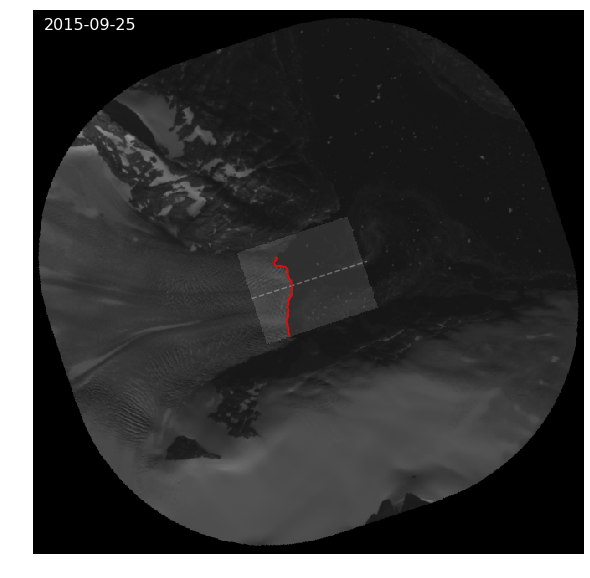

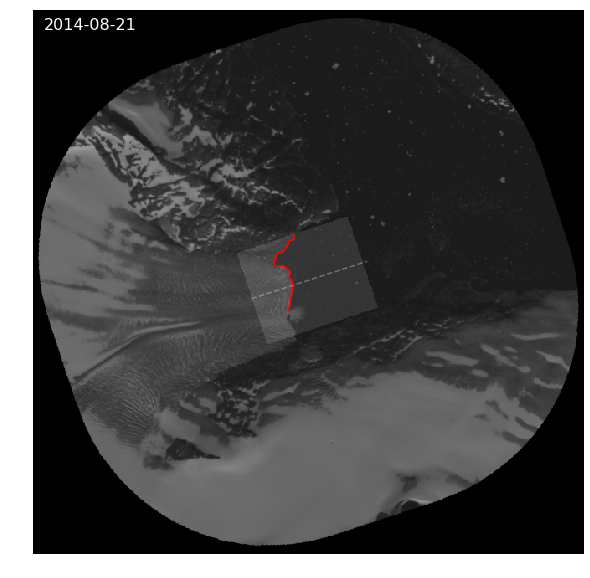

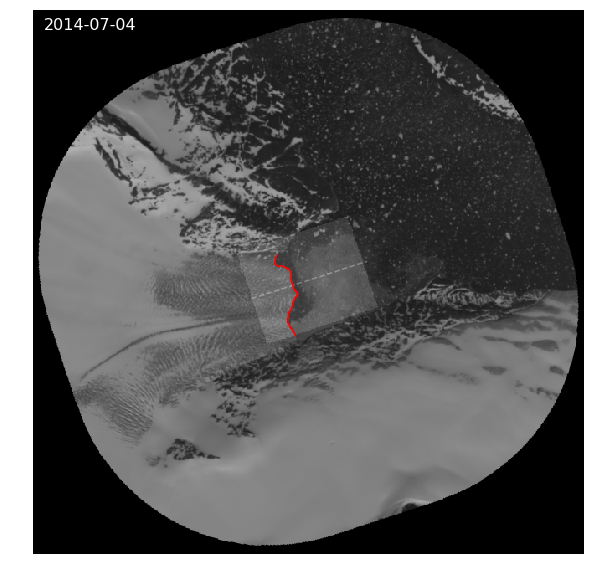

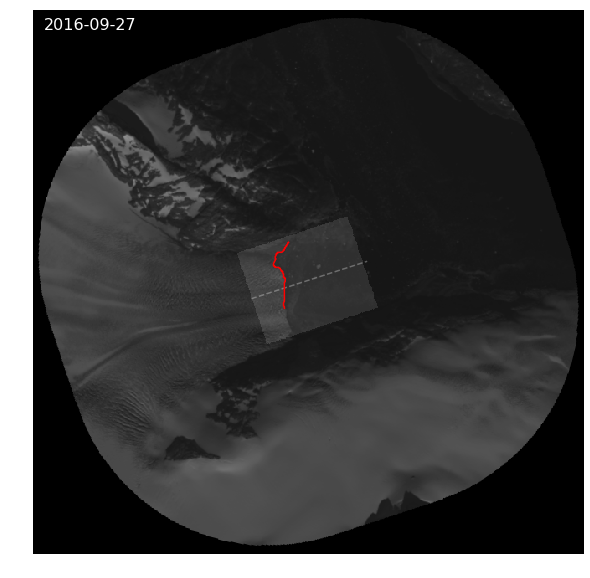

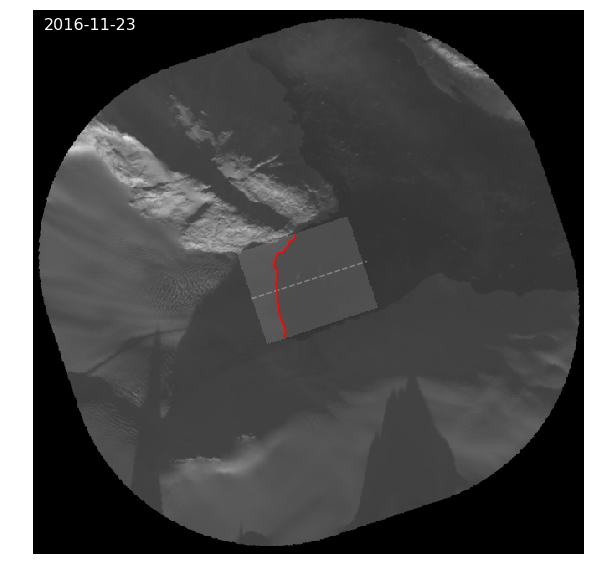

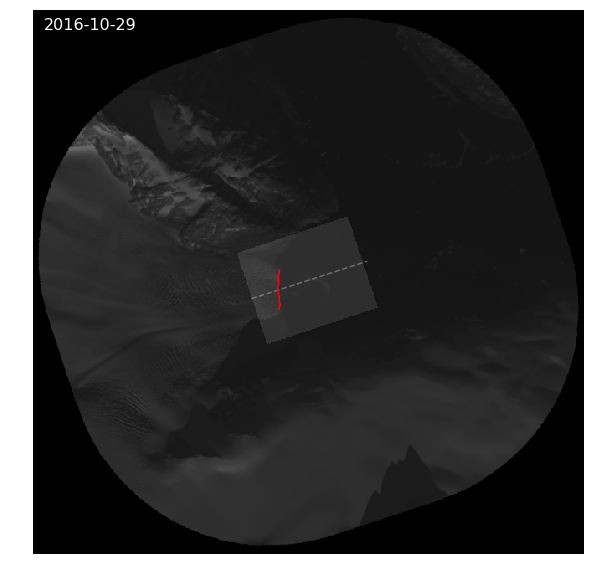

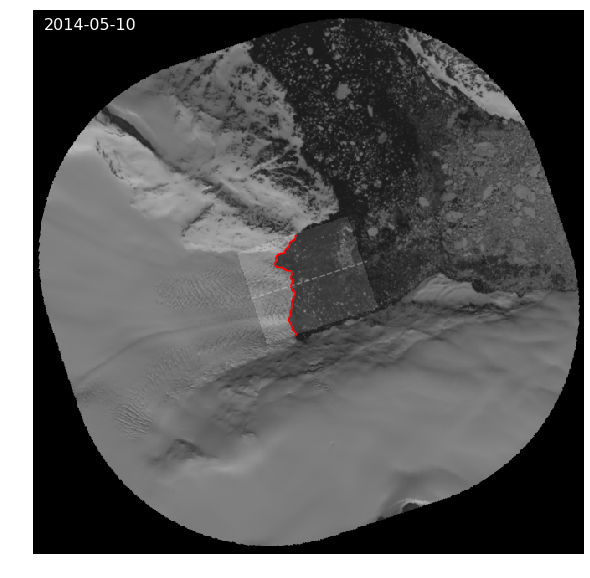

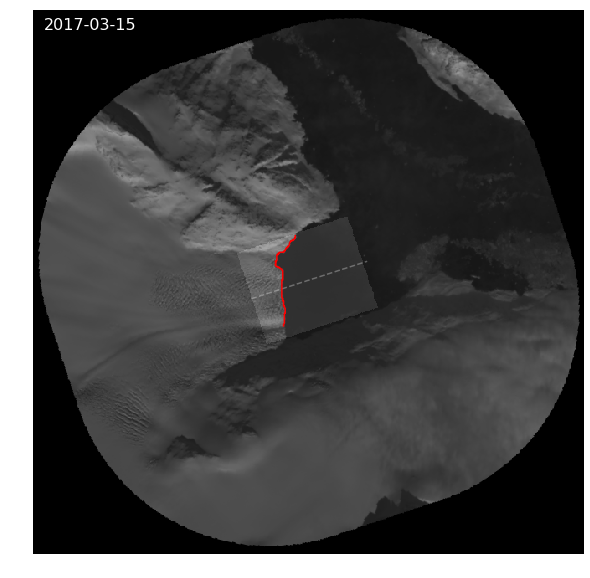

In [1522]:
# for index, row in dated_images_df.iterrows():
uniquescenes = set(list(final_images_df['Scene']))
len(uniquescenes)

for scene in uniquescenes:    
    #separate the df by scene:
    scene_df = final_images_df[final_images_df['Scene'] == scene].copy()
    #sort by descending order so the worse orders are plotted first and the better orders are plotted on top
    scene_df = scene_df.sort_values(by='Order', ascending=False)
    
    #grab the date for the scene (just use the first since all should be the same)
    date = list(scene_df.datetimes)[0]
    
    #loop through the rows for each scene
    trimdatfiles = []
    datfiles = []
    orders = []
    intersections = []
    
    for index, row in scene_df.iterrows():
        #grab the terminus_trim files and append to list
        trimdatfiles.append(row['Trimmed_dat_filename'])
        datfiles.append(row['Dat_filename'])
        #grab the order to be plotted later:
        orders.append(row['Order'])
        #grab the intersections to be plotted later:
        intersections.append(row['intersections'])

    #Read in the image.png as np array
    image = mpimg.imread(imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+'.png')
    
    #Read in terminus box raster as an np array
    tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.png")
    
    #set path to that image's datfiles:
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    
    #grab dat xs and ys
    datxs = {}
    datys = {}
    
    for i in range(0, len(trimdatfiles)):
        trimdat = trimdatfiles[i]
        dat = datfiles[i]
#         print(trimdat)
        #Read in dat file as np array and grab x and y values
        term_trim_dat = np.loadtxt(datpath+trimdat)
#         term_dat = np.loadtxt(datpath+dat)
#         print(term_trim_dat.shape)
        
        xs = []
        ys = []
        #grab x and y coordinates for the terminus line
        for j in term_trim_dat:
            x, y = (j[0], j[1])
            xs.append(x)
            ys.append(y)
        
        #update into dat xs and ys dictionaries:
        datxs.update({trimdat: xs})
        datys.update({trimdat: ys})
        
    #PLOT THE LANDSAT IMAGE and TERMINUS BOX
    plt.figure(figsize=(20,10))
    plt.axis("off")
    imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    boxplt = plt.imshow(tbox, alpha=0.1)
    
    #PLOT CENTERLINE
    #grab slope and intercept from the dataframe
    c_slope = float(centerline_df.loc[BOI]['cline_slope'])
    c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
    #grab x values from width of the terminus box array:
    xmin = float(centerline_df.loc[BOI]['midpoint_x'])
    xmax = np.max(np.array(list(set(np.nonzero(tbox)[0]))))
    c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
    c_y = c_slope*c_x + c_intercept
    plt.plot(c_x, c_y, '--w', linewidth=1.5, alpha=0.3)

    #PLOT DATE in the top left corner
    plt.text(int(0.02*image.shape[0]), int(0.035*image.shape[1]), str(date)[:-9], fontsize=16, color='w')
    
    #PLOT TOP PICK in purple
    toppick = trimdatfiles[len(trimdatfiles)-1]
    plt.plot(datxs[toppick], datys[toppick], color='r')
    
    
    #PLOT ALL TOP PICKS in different shades of purple
    #create five shades for each order
    colors = pl.cm.plasma(np.linspace(0,1,5))
    col_count = 0
    #plot number of lines
#     plt.text(int(0.02*image.shape[0]), int(0.07*image.shape[0]), "Lines: "+str(len(trimdatfiles)), fontsize=16, color='w')
    #plot each termline
    for line in trimdatfiles:
        #grab the x and y values for that termline
        x, y = datxs[line], datys[line]
        #plot with color scheme
        plt.plot(x, y, color=colors[col_count], linewidth=2)
        col_count = col_count+1
    
#     #PLOT intersection points
#     for i_point in intersections:
#         plt.plot(i_point[0], i_point[1], 'kx', markersize='6')
        
    #PLOT midpoint for figure
#     plt.plot(float(centerline_df.loc[BOI]['midpoint_x']), float(centerline_df.loc[BOI]['midpoint_y']), 'ko', markersize='4')
      
    #SAVE AND DELAY
    plt.savefig(basepath+"Box"+BOI+"/Results/"+str(date)[:-9]+"_"+massorsize+"_trim_"+scene+".png", dpi=100, bbox_inches='tight')
#     plt.show()
    
#     sleep(2)
#     clear_output()
# print("Done.")

## 4) Plot terminus position and change rate timeseries

In [1513]:
#simplify the dataframe for future procesing
# final_images_df = final_images_df.drop(['Image_array', 'Dat_filename', 'Trimmed_dat_filename', 'Metric', 'intersections'], axis=1)

#reset index for final_images_df
final_images_df = final_images_df.reset_index(drop=True)

### Filtering using max flow speeds

Grab max flow threshold from glacier velocities:

In [1514]:
#Grab max flow threshold from glacier velocities in flowspeed_df
max_flow = float(flowspeed_df['Max_speed'][BOI])
if max_flow < 1.0:
    flow_thresh = 5.0
else:
    flow_thresh = 5.0*max_flow
print(flow_thresh)

5.0


Filter for sudden dips in the time series:

In [1515]:
#REMOVE DIPS ITERATIVELY n=5 times
nodips = remove_dips(final_images_df, flow_thresh, 6)
# final_images_df = remove_dips(final_images_df, flow_thresh, 1)

[13, 15, 17, 23, 24, 25, 26, 27, 103, 104]
[14]
[93]
[13, 88, 89, 90, 91, 92]
[82, 84, 86]
[82]


Filter for sudden jumps in the time series

In [1516]:
#REMOVE JUMPS ONCE
nojumps = remove_jumps(nodips, flow_thresh, 3)
# final_images_df = remove_jumps(final_images_df, flow_thresh, 1)

[5, 6, 7, 13, 14, 15, 16, 17, 83]
[]
[]


In [1496]:
df1 = final_images_df[final_images_df['Order'] == '1'].copy()
df2 = final_images_df[final_images_df['Order'] == '2'].copy()
df3 = final_images_df[final_images_df['Order'] == '3'].copy()
df4 = final_images_df[final_images_df['Order'] == '4'].copy()
df5 = final_images_df[final_images_df['Order'] == '5'].copy()

In [1475]:
max_pos = np.max(np.array(onepick_df['term_position']))

In [1478]:
adjusted_tpos = np.array(onepick_df['term_position']) - max_pos

[[0.050383 0.029803 0.527975 1.      ]
 [0.494877 0.01199  0.657865 1.      ]
 [0.798216 0.280197 0.469538 1.      ]
 [0.973416 0.585761 0.25154  1.      ]
 [0.940015 0.975158 0.131326 1.      ]]


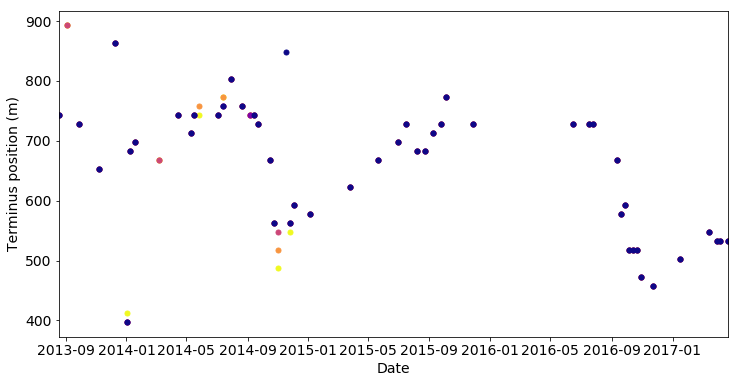

In [1497]:
fig, ax1 = plt.subplots(figsize=(12,6))
# ax1.plot(final_images_df['datetimes'], final_images_df['term_position'], 'mo', markersize = 5)

colors = pl.cm.plasma(np.linspace(0,1,5))
print(colors)

#TERMINUS POSITION
# ax1.plot(nodips['datetimes'], nodips['term_position'], 'mo', markersize='4')
# ax1.plot(dips_df['datetimes'], dips_df['Term_position'], 'ko', markersize='4')
# ax1.plot(onepick_df['datetimes'], adjusted_tpos, color=colors[0], marker='o', markersize='5', lw=0)


ax1.plot(df5['datetimes'], df5['term_position'], color = colors[4], marker='o', markersize=5, lw=0)
ax1.plot(df4['datetimes'], df4['term_position'], color = colors[3], marker='o', markersize=5, lw=0)
ax1.plot(df3['datetimes'], df3['term_position'], color = colors[2], marker='o', markersize=5, lw=0)
ax1.plot(df2['datetimes'], df2['term_position'], color = colors[1], marker='o', markersize=5, lw=0)
ax1.plot(df1['datetimes'], df1['term_position'], color = colors[0], marker='o', markersize=5, lw=0)

ax1.set_ylabel('Terminus position (m)', color='k', fontsize=14)
# ax1.set_ylim(-20, 1800)
# ax1.set_ylim(-195,5)
ax1.set_xlim(min_time, max_time)
ax1.set_xlabel('Date', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

# plt.savefig(csvpaths+"/Figures/filtering/Timeseries_final_top1_"+BOI+"_"+analysis_date+".png", dpi=500)
plt.show()

In [1493]:
min_time = list(final_images_df['datetimes'])[0]
max_time = list(final_images_df['datetimes'])[-1]

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
#TERMINUS POSITION
ax1.plot(nojumps['datetimes'], nojumps['term_position'], 'mo', markersize='4')
# ax1.plot(dips_df['datetimes'], dips_df['Term_position'], 'ko', markersize='4')
plt.show()

Grab only those terminus positions corresponding to the highest order terminus pick.

In [1462]:
# nojumps = final_images_df

In [1517]:
#grab unique dates
unique_dates = set(list(nojumps['datetimes']))
print(len(unique_dates))

#grab highest order:
order_list = []
for date in unique_dates:
    date_df = nojumps[nojumps['datetimes'] == date].copy()
    highestorder = np.min(np.array(date_df['Order']))
    order_list.append(highestorder)

#create highestorder_df
highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order'])
highestorder_df = highestorder_df.sort_values(by='datetimes', ascending=True)
# highestorder_df.head()

46


Inner merge with final_images_df to only keep those of the highest order

In [1518]:
onepick_df = nojumps.merge(highestorder_df, how='inner', on=['datetimes', 'Order'])
print(onepick_df.shape[0])
onepick_df

46


Scene BoxID  \
0   LC82330172013230LGN00   174   
1   LC82320172013271LGN00   174   
2   LC82330172014009LGN00   174   
3   LC82320172014018LGN00   174   
4   LC82320172014066LGN00   174   
5   LC82330172014105LGN00   174   
6   LC82320172014130LGN00   174   
7   LC82330172014137LGN00   174   
8   LC82320172014146LGN00   174   
9   LC82330172014185LGN00   174   
10  LC82320172014194LGN00   174   
11  LC82320172014210LGN00   174   
12  LC82330172014233LGN00   174   
13  LC82330172014249LGN00   174   
14  LC82320172014258LGN00   174   
15  LC82330172014265LGN00   174   
16  LC82320172014290LGN00   174   
17  LC82330172014329LGN00   174   
18  LC82320172014338LGN00   174   
19  LC82320172015005LGN00   174   
20  LC82320172015085LGN00   174   
21  LC82330172015140LGN00   174   
22  LC82320172015181LGN00   174   
23  LC82320172015197LGN00   174   
24  LC82330172015220LGN00   174   
25  LC82330172015236LGN00   174   
26  LC82330172015252LGN00   174   
27  LC82330172015268LGN00   174   
28  LC82320172015277LGN00   174   
29  LC82330172015332LGN00   174   
30  LC82320172016168LGN00   174   
31  LC82320172016200LGN00   174   
32  LC82330172016207LGN00   174   
33  LC82330172016255LGN00   174   
34  LC82320172016264LGN00   174   
35  LC82330172016271LGN00   174   
36  LC82320172016280LGN00   174   
37  LC82330172016287LGN00   174   
38  LC82320172016296LGN00   174   
39  LC82330172016303LGN00   174   
40  LC82320172016328LGN00   174   
41  LC82330172017017LGN00   174   
42  LC82320172017074LGN00   174   
43  LC82320172017090LGN00   174   
44  LC82330172017097LGN00   174   
45  LC82330172017113LGN00   174   

                                          Image_array      Dat_filename  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_006.dat   
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
12  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
13  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
15  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
16  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
17  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
18  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
19  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
20  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
21  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
22  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_006.dat   
23  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
24  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
25  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
26  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
27  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
28  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
29  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
30  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [1504]:
# onepick_df = final_images_df.merge(highestorder_df, how='inner', on=['datetimes', 'Order'])
# print(onepick_df.shape[0])
# onepick_df

In [ ]:
# df1 = final_images_df[final_images_df['Order'] == '1'].copy()
# df2 = final_images_df[final_images_df['Order'] == '2'].copy()
# df3 = final_images_df[final_images_df['Order'] == '3'].copy()
# df4 = final_images_df[final_images_df['Order'] == '4'].copy()
# df5 = final_images_df[final_images_df['Order'] == '5'].copy()

## Plotting:

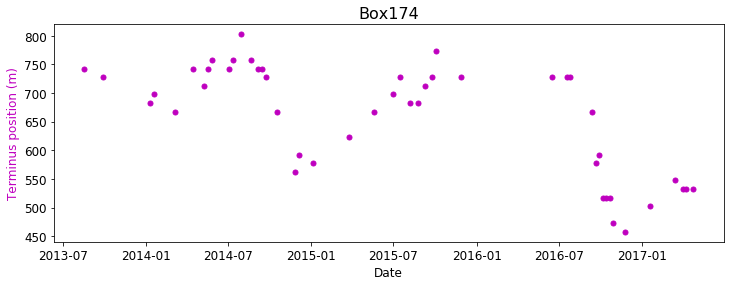

In [1519]:
fig, ax1 = plt.subplots(figsize=(12,4))
#TERMINUS POSITION
# ax1.plot(df5['datetimes'], df5['term_position'], 'ys', markersize='4')
# ax1.plot(df4['datetimes'], df4['term_position'], 'gx', markersize='4')
# ax1.plot(df3['datetimes'], df3['term_position'], 'c*', markersize='4')
# ax1.plot(df2['datetimes'], df2['term_position'], 'b^', markersize='4')
# ax1.plot(df1['datetimes'], df1['term_position'], 'mo', markersize='5')
ax1.plot(onepick_df['datetimes'], onepick_df['term_position'], 'mo', markersize='5')

# final_images_df.plot(x='datetimes', y='term_position', 
#             c=final_images_df['Order'], markersize='4', colormap='RdPu_r', legend=None)
ax1.set_ylabel('Terminus position (m)', color='m', fontsize=12)

#TERMINUS CHANGE RATES
# ax2 = ax1.twinx()
# ax2.plot(onepick_df['datetimes'], onepick_df['changerate'], 'bo', markersize='5', alpha=0.5)
# ax2.set_ylabel('Terminus change rate (m/d)', color = 'b', fontsize=12)

#GENERAL PLOT PARAMETERS
ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=12)

#SAVE FIGURE
# plt.savefig(csvpaths+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+analysis_date+".png", dpi=200)
plt.show()

In [ ]:
# for idx, row in onepick_df.iterrows():
#     if row['term_position'] > 2500:
#         print(row['datetimes'], idx, '%.2f' % row['changerate'])

In [ ]:
onepick_df.to_csv(path_or_buf = csvpaths+'Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')